## Additional Modeling using Neural Network.  

It is a common approach for small amount of data, such as this homework, the data scientis would use traditional modeling techniques, such as SVM, ensemble learning algorithm or tree based algorithm. But leave neural network out of discussion. 

As short of learning samples, would make neural network harder to generalise and tuning parameters. 

But there are cerain good properties in Neural Network, such as auto feature engineering, ability to scope to larger dataset, would still make it a valid candidate to build a baseline model. 

In this code, I would use pytorch as my deep learning framework. 

In [1]:
!pip install --upgrade torch | tail -n 1

In [2]:
!pip install --upgrade tensorboard | tail -n 1

In [3]:
import torch 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from tqdm.notebook import tqdm
tqdm.pandas()

In [4]:
## Common methods to load and preprocess data
def load_data(filepath):
    
    columns = ['index','age','breed','last_vet_visit','hair_length','height','num_vet_visit','weight']
    
    return pd.read_csv(filepath,names=columns,header=0)

def remove_negative_value(df, columns):
    # df: dataframe of the data 
    # columns: list of columns need to remove negative value from 
    
    if len(columns) == 0 and df.empty:
        return df
    
    for col in columns:
        df = df[df[col]>=0]
    
    return df


def remove_extreme_outliers(df,columns):
    #for values great then quantile 99.9% then it would be treated as exterm outlier 
    # df: dataframe of the data 
    # columns: list of columns need to remove negative value from 
    
    if len(columns) == 0 and df.empty:
        return df
    
    for col in columns:
        limit = df[col].quantile(0.999)
        df = df[df[col]<limit] 
        
    return df


def preprocess():
    
    filepath='data.csv'

    df = load_data(filepath)

    #remove  column 
    df = df.drop(columns=['index','last_vet_visit'])

    #remove any negative value
    df = remove_negative_value(df,['age','hair_length','height','num_vet_visit','weight'])

    #remove any exterme outliers
    df = remove_extreme_outliers(df,['age','hair_length','height','num_vet_visit','weight'])
 
    #split training, test and validation set
    val_size = 0.2 
    test_size = 0.15
    
    df_temp,df_test = train_test_split(df, test_size=test_size,random_state=1)
    df_train,df_val = train_test_split(df_temp, test_size=val_size,random_state=1)
    
    return df_train,df_test,df_val

In [5]:
train,test,val=preprocess()
print('train size {}, test size {}, validation size {}'.format(train.shape,test.shape,val.shape))

train size (196, 6), test size (44, 6), validation size (50, 6)


In [6]:
#Dataset class
class CatDataset(torch.utils.data.Dataset):
    
    category_cols = ['breed']
    numerical_cols = ['hair_length','height','num_vet_visit','weight']


    def initTransformer(self):
        return make_pipeline(
            ColumnTransformer([
                ('num', StandardScaler(), self.numerical_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), self.category_cols),    
            ])
        )
        
    def get_transformer(self):
        return self.transformer
    
    def __init__(self, df, transformer=None):
        super().__init__()
        self.df = df
        
        if transformer is None:
            self.transformer = self.initTransformer()
            self.transformer.fit(df)
        else:
            self.transformer = transformer

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):

        # Load data and get label
        y = torch.tensor(self.df.iloc[[index]]['age'].values,dtype=torch.float32)
        X = torch.tensor(self.transformer.transform(self.df.iloc[[index]].drop(columns=['age'])),dtype=torch.float32)

        return X, y

In [17]:
trainDS = CatDataset(train)
transformer = trainDS.get_transformer()
testDS = CatDataset(test,transformer)
valDS = CatDataset(val,transformer)

# Parameters
params = {'batch_size': 100,
          'shuffle': True,
          'drop_last': True}

trainDL = DataLoader(trainDS, **params)

testDL = DataLoader(testDS)
valDL = DataLoader(valDS)

print(len(trainDL), len(testDL), len(valDL))

1 44 50


In [8]:
X, y = next(iter(valDL))
# print(X)
print(X.shape)

torch.Size([1, 1, 10])


In [9]:
# Model Class
# Fully connected neural network with four hidden layers
class FeedForward(nn.Module):
    
    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)    
    
    def __init__(self, input_size):
        super().__init__()
        
        self.net = nn.Sequential(
            
            nn.Linear(input_size, 20), 
            nn.ReLU(),
            nn.BatchNorm1d(20),
            nn.Dropout(),
            nn.Linear(20, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
#             nn.Dropout(),
            nn.Linear(50, 20),
            nn.ReLU(),
#             nn.BatchNorm1d(20),
# #             nn.Dropout(),
#             nn.Linear(20, 50),
#             nn.ReLU(),
#             nn.BatchNorm1d(50),            
#             nn.Dropout(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.BatchNorm1d(20),            
#             nn.Dropout(),            
            nn.Linear(20, 1)
        )
        
        self.net.apply(self.init_weights)
    
    def forward(self, X):
        return self.net(X)
    
    def predict(self, X):
        Y_pred = self.forward(X)
        return Y_pred

In [10]:
# Network params
X, y = next(iter(trainDL))
input_size = X.shape[2]

# Early Stop parameters
n_epochs_stop = 4
epochs = 150

In [11]:
## create model class and set up optimiser
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FeedForward(input_size).to(device)

loss_fn = torch.nn.MSELoss()

# optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
optimiser = torch.optim.AdamW(model.parameters())

In [12]:
print(model)


FeedForward(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=20, out_features=50, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=50, out_features=20, bias=True)
    (8): ReLU()
    (9): Linear(in_features=20, out_features=20, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [13]:
ageScaler = StandardScaler().fit(train['age'].values.reshape(-1,1))

In [14]:
def mean(l):
    return sum(l)/len(l)

import copy


results = []
losses = {'epoch':[], 'training':[],'validation':[]}
min_val_loss = 100
epochs_no_improve = 0
model_state_dict = {}


for i in range(epochs):
    loss_t = []
    model = model.train()
    
    t = tqdm(iter(trainDL), total=len(trainDL),desc='Training Progress')
    for  itercount, (X, y) in enumerate(t):
        optimiser.zero_grad()

        X = X.view(-1,input_size)
        y_pred = model(X)

    
        y = torch.tensor(ageScaler.transform(y),dtype=torch.float32)
   

        single_loss = loss_fn(y_pred, y)
        single_loss.backward()
        optimiser.step()
        
        loss_t.append(single_loss.item()) 

    
    print('epoch: {}, Training average loss: {}'.format(i,mean(loss_t)))

    
    #evaluate model every epoch
    model = model.eval()

    loss_v = []
    with torch.no_grad():
        for X,y in valDL:
            X, y = X.to(device), y.to(device)
            X = X.view(-1,input_size)
            y_pred = model(X)
            y = torch.tensor(ageScaler.transform(y),dtype=torch.float32)
#             y_pred = torch.tensor(ageScaler.inverse_transform(y_pred),dtype=torch.float32)
            single_loss = loss_fn(y_pred,y)
            loss_v.append(single_loss.item())
#         results = [y,y_pred]

    print('           Validation average loss: {}'.format(mean(loss_v)))
    
    

    
    #store loss value
    losses['epoch'].append(i)
    losses['training'].append(mean(loss_t))
    losses['validation'].append(mean(loss_v))
    
    #check early stop
    if mean(loss_v) > min_val_loss:
        epochs_no_improve += 1
    else:
        min_val_loss = mean(loss_v)
        model_state_dict = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        
    print('           Minimum Validation loss: {}'.format(min_val_loss))
        
        
    if epochs_no_improve >= n_epochs_stop:
        print('           Early Stop!!!!! After {} epochs validation loss not improving '.format(epochs_no_improve))
        break
    

#run blindTest set to get result
best_model = FeedForward(input_size).to(device)
best_model.load_state_dict(model_state_dict)
best_model = best_model.eval()
model = model.eval()
loss_bt = []
least_loss_bt = []

with torch.no_grad():
    for X,y in testDL:
        X, y = X.to(device), y.to(device)
        X = X.view(-1,input_size)
        y_pred = model(X)
        y_pred = torch.tensor(ageScaler.inverse_transform(y_pred),dtype=torch.float32)
        y_pred_best = best_model(X)
        y_pred_best = torch.tensor(ageScaler.inverse_transform(y_pred_best),dtype=torch.float32)
        single_loss = loss_fn(y_pred,y)
        least_loss = loss_fn(y_pred_best,y)
        loss_bt.append(single_loss.item())
        least_loss_bt.append(least_loss.item())
        results = [y,y_pred]
#         print(y,y_pred)
        
print('Best BlindTest loss: {}'.format(mean(least_loss_bt)))    
print('BlindTest loss: {}'.format(mean(loss_bt)))


epoch: 0, Training average loss: 2.7235934734344482
           Validation average loss: 1.0267897789098788
           Minimum Validation loss: 1.0267897789098788



epoch: 1, Training average loss: 1.9644296169281006
           Validation average loss: 1.1021663898974656
           Minimum Validation loss: 1.0267897789098788



epoch: 2, Training average loss: 2.181762139002482
           Validation average loss: 1.1713780821686306
           Minimum Validation loss: 1.0267897789098788



epoch: 3, Training average loss: 2.2533584038416543
           Validation average loss: 1.2142127260460984
           Minimum Validation loss: 1.0267897789098788



epoch: 4, Training average loss: 1.5944971243540447
           Validation average loss: 1.2203169516517665
           Minimum Validation loss: 1.0267897789098788
           Early Stop!!!!! After 4 epochs validation loss not improving 
Best BlindTest loss: 9.245459896776909
BlindTest loss: 10.74085316349837


<AxesSubplot:xlabel='epoch'>

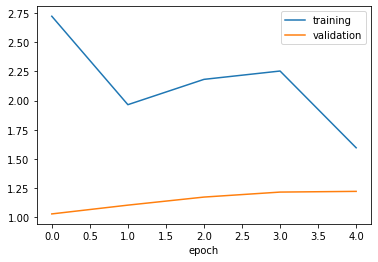

In [15]:
#visualize training loss
losses_df = pd.DataFrame(data=losses)

losses_df.set_index('epoch').plot()

In [16]:
## save model

# from joblib import dump, load
# transformer = trainDS.get_transformer()
# dump(transformer,'transformer_torch.joblib')


# torch.save(model, 'torchmodel')